# GRAEP Tutorial: Differentiable Analysis in High Energy Physics

**Duration**: ~20 minutes

## What You'll Learn

This tutorial shows you how to make a physics analysis fully differentiable and optimize it using gradients. Three core components:

1. **Soft cuts**: Replace hard selections with smooth, differentiable functions
2. **Differentiable histograms**: Use binned KDE for gradient-friendly histogramming
3. **Statistical inference**: Build differentiable significance with evermore

We'll compose these into a complete GRAEP-style workflow that automatically finds optimal selections.

## The Physics Problem

We're searching for a Z' boson decaying to top quark pairs (Z' → ttbar).

- **Signal**: Z' → ttbar (rare, what we want)
- **Backgrounds**: SM ttbar, W+jets

**Traditional**: Manually tune cuts through trial and error  
**GRAEP**: Treat analysis as differentiable function, optimize with gradients

$$
\text{Significance} = f(\text{data}, \theta) \quad \text{where } \theta = \{\text{MET cut}, \text{b-tag cut}, \ldots\}
$$

Find optimal cuts: $\theta^* = \arg\max_\theta \text{Significance}(\theta)$ using gradient ascent

In [1]:
# Part 1: Setup

import jax
import jax.numpy as jnp
from jax import grad, jit, random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
import mplhep as hep
import optax
from pathlib import Path
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich.panel import Panel

# Set random seeds
np.random.seed(42)
key = random.PRNGKey(42)

console = Console()

console.print(f"[magenta]JAX version:[/magenta] {jax.__version__}")
console.print(f"[magenta]JAX backend:[/magenta] {jax.default_backend()}")

JAX version: 0.7.0

JAX backend: cpu

## Part 2: Load and Explore Data

We'll use pre-processed CMS Open Data (2016).

In [2]:
# Load tutorial data
data_dir = Path("tutorial_data")

# Load each process
data_obs = np.load(data_dir / "data.npz")
wjets_data = np.load(data_dir / "wjets.npz")
ttbar_data = np.load(data_dir / "ttbar.npz")
signal_data = np.load(data_dir / "signal.npz")

# Display dataset info with rich table
table = Table(title="Dataset Overview", show_header=True, header_style="bold cyan")
table.add_column("Process", style="cyan", width=20)
table.add_column("Events", justify="right", style="green")
table.add_column("Type", style="yellow")

table.add_row("Data (CMS)", f"{len(data_obs['n_jet']):,}", "Real collisions")
table.add_row("W+jets", f"{len(wjets_data['n_jet']):,}", "MC background")
table.add_row("ttbar", f"{len(ttbar_data['n_jet']):,}", "MC background")
table.add_row("Signal (Z')", f"{len(signal_data['n_jet']):,}", "MC signal")

console.print(table)

# Available features
features = [k for k in wjets_data.keys() if k != 'weight']
console.print(f"\n[cyan]Features:[/cyan] {', '.join(features[:6])}...")
console.print(f"[cyan]Total:[/cyan] {len(features)} kinematic variables per event")

                  Dataset Overview                  
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Process              ┃  Events ┃ Type            ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Data (CMS)           │   4,048 │ Real collisions │
│ W+jets               │      32 │ MC background   │
│ ttbar                │ 102,171 │ MC background   │
│ Signal (Z')          │  36,294 │ MC signal       │
└──────────────────────┴─────────┴─────────────────┘

Features: n_jet, leading_jet_mass, subleading_jet_mass, leading_jet_pt, subleading_jet_pt, st...

Total: 13 kinematic variables per event

In [3]:
# Convert all data to JAX arrays (do this ONCE at the start)
# From now on, we work with JAX arrays everywhere!

def convert_to_jax(data_dict):
    """Convert all arrays in dictionary to JAX arrays."""
    return {k: jnp.array(v) for k, v in data_dict.items()}

wjets_data = convert_to_jax(wjets_data)
ttbar_data = convert_to_jax(ttbar_data)
signal_data = convert_to_jax(signal_data)
data_obs = convert_to_jax(data_obs)

console.print("[green]✓ All data converted to JAX arrays[/green]")
console.print("  From now on, we work with JAX (not NumPy)")

✓ All data converted to JAX arrays

From now on, we work with JAX (not NumPy)

### Event Weights and Normalization

MC events have genWeights. We apply proper normalization: `weight = genWeight × lumi × xsec / N_gen`

In [4]:
# Apply proper normalization
wjets_weights = wjets_data['weight']
ttbar_weights = ttbar_data['weight']
signal_weights = signal_data['weight']
console.print("\n[green]Applied proper cross-section normalization to MC weights.[/green]")
console.print("Total weights after normalization:")
console.print(f"  W+jets: {jnp.sum(wjets_weights):.2f}")
console.print(f"  ttbar:  {jnp.sum(ttbar_weights):.2f}")
console.print(f"  Signal: {jnp.sum(signal_weights):.2f}")
console.print(f"  Data:   {jnp.sum(data_obs['weight']):.2f}")

Applied proper cross-section normalization to MC weights.

Total weights after normalization:

W+jets: 398.84

ttbar:  3863.41

Signal: 1128.86

Data:   4048.00

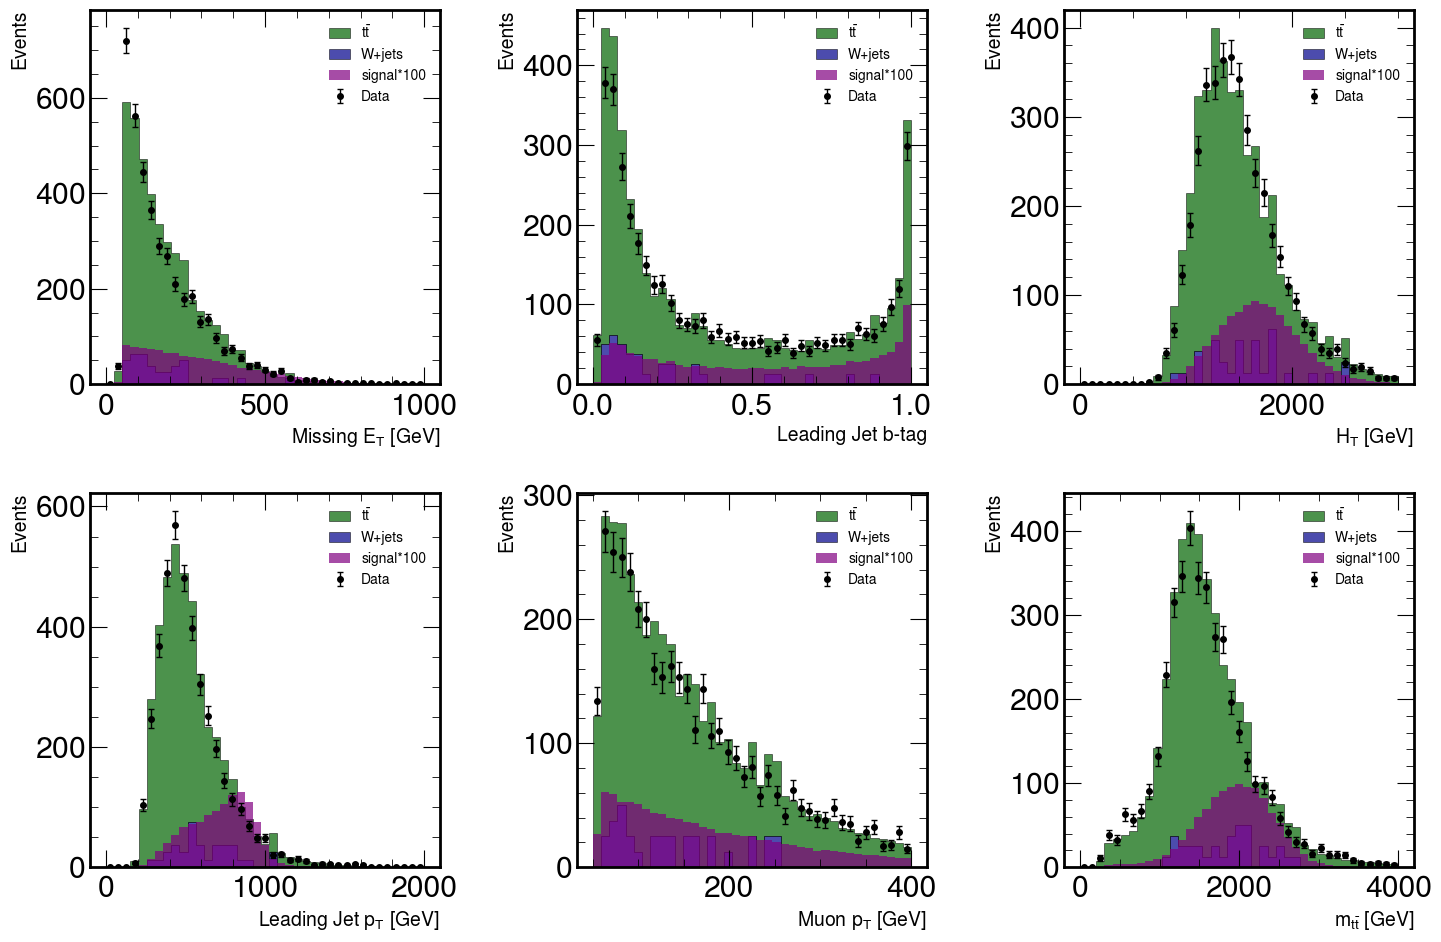

✓ Data/MC agreement looks as expected

In [5]:
# Data vs MC comparison using CMS style
hep.style.use("CMS")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features_to_plot = [
    ('met_pt', r'Missing $E_T$ [GeV]', jnp.linspace(0, 1000, 40)),
    ('leading_jet_btag', 'Leading Jet b-tag', jnp.linspace(0, 1, 40)),
    ('st', r'$H_T$ [GeV]', jnp.linspace(0, 3000, 40)),
    ('leading_jet_pt', 'Leading Jet $p_T$ [GeV]', jnp.linspace(0, 2000, 40)),
    ('muon_pt', r'Muon $p_T$ [GeV]', jnp.linspace(50, 400, 40)),
    #('n_jet', 'Number of Jets', jnp.arange(2, 18)),
    ('m_ttbar', r'$m_{t\bar{t}}$ [GeV]', jnp.linspace(0, 4000, 40)),

]

for ax, (feature, label, bins) in zip(axes, features_to_plot):
    # Stack MC backgrounds manually
    wjets_hist, _ = jnp.histogram(wjets_data[feature], bins=bins, weights=wjets_weights)
    ttbar_hist, _ = jnp.histogram(ttbar_data[feature], bins=bins, weights=ttbar_weights)

    hep.histplot(
        [wjets_hist, ttbar_hist],
        bins=bins,
        stack=True,
        ax=ax,
        label=['W+jets', r't$\bar{t}$'],
        color=['darkblue', 'darkgreen'],
        edgecolor='black',
        histtype='fill',
        linewidth=0.5,
        alpha=0.7
    )

    # Signal overlay
    signal_hist, _ = jnp.histogram(signal_data[feature], bins=bins, weights=signal_weights) # Scale signal for visibility
    hep.histplot(
        signal_hist,
        bins=bins,
        ax=ax,
        label="signal*100",
        histtype='fill',
        linewidth=2,
        color='purple',
        alpha=0.7
    )

    # Data points
    data_counts, _ = jnp.histogram(data_obs[feature], bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2 if not isinstance(bins, range) else np.array(list(bins))[:-1] + 0.5

    ax.errorbar(
        bin_centers, data_counts,
        yerr=jnp.sqrt(data_counts),
        fmt='o', color='black',
        markersize=4, capsize=2,
        label='Data', linewidth=1
    )

    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Events', fontsize=14)
    ax.legend(fontsize=10, frameon=False)
    ax.set_ylim(bottom=0)
    # Use scientific notation in LaTeX style
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Force scientific notation outside this range

    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))

plt.tight_layout()
plt.savefig('data_mc_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

console.print("[green]✓[/green] Data/MC agreement looks as expected")

## Part 3: Differentiable Cuts

**What you know**: Selection cuts filter events (e.g., MET > 100 GeV → accept/reject)

**What's new**: Soft cuts use sigmoid functions → smooth transition from 0 to 1

**Why it matters**: Smooth = differentiable = we can compute ∂(efficiency)/∂(cut threshold)!

### Soft Selection with Sigmoid

Traditional HEP cuts are **hard**: event either passes (weight=1) or fails (weight=0).

For optimization, we need **soft cuts**: smooth transitions using sigmoid functions.

$$
w_{\text{soft}} = \sigma\left(\frac{x - \text{threshold}}{T}\right) = \frac{1}{1 + e^{-(x - \text{threshold})/T}}
$$

where $T$ is the temperature (controls smoothness).

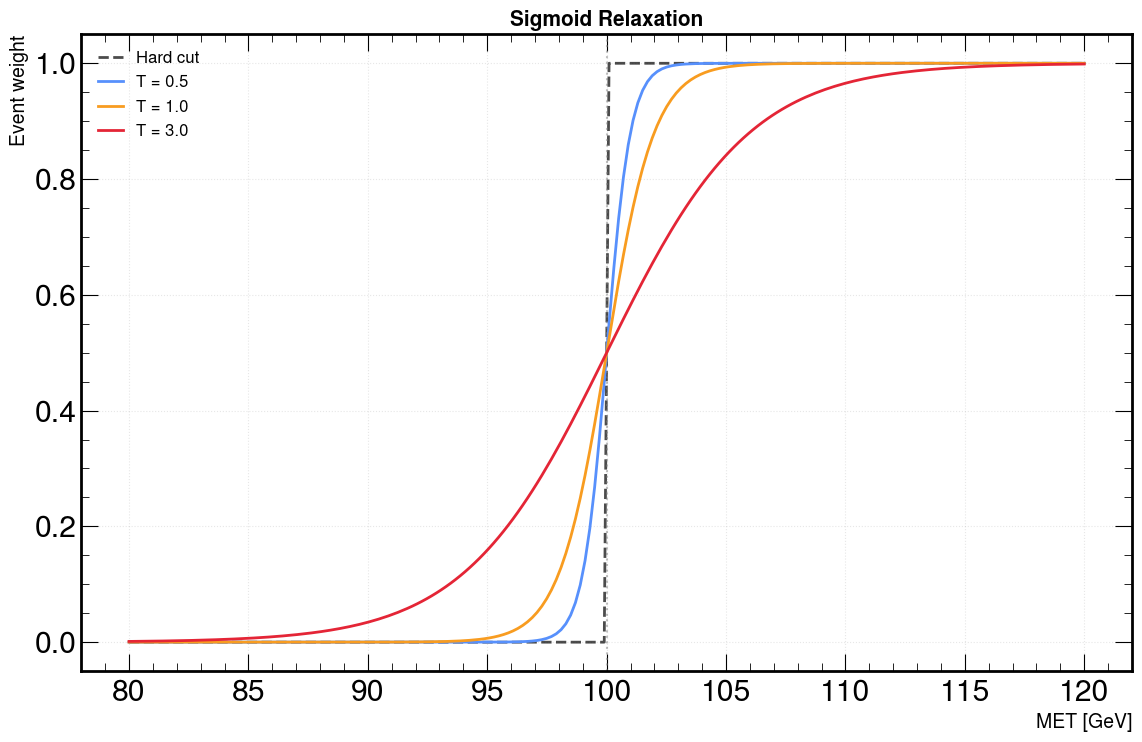

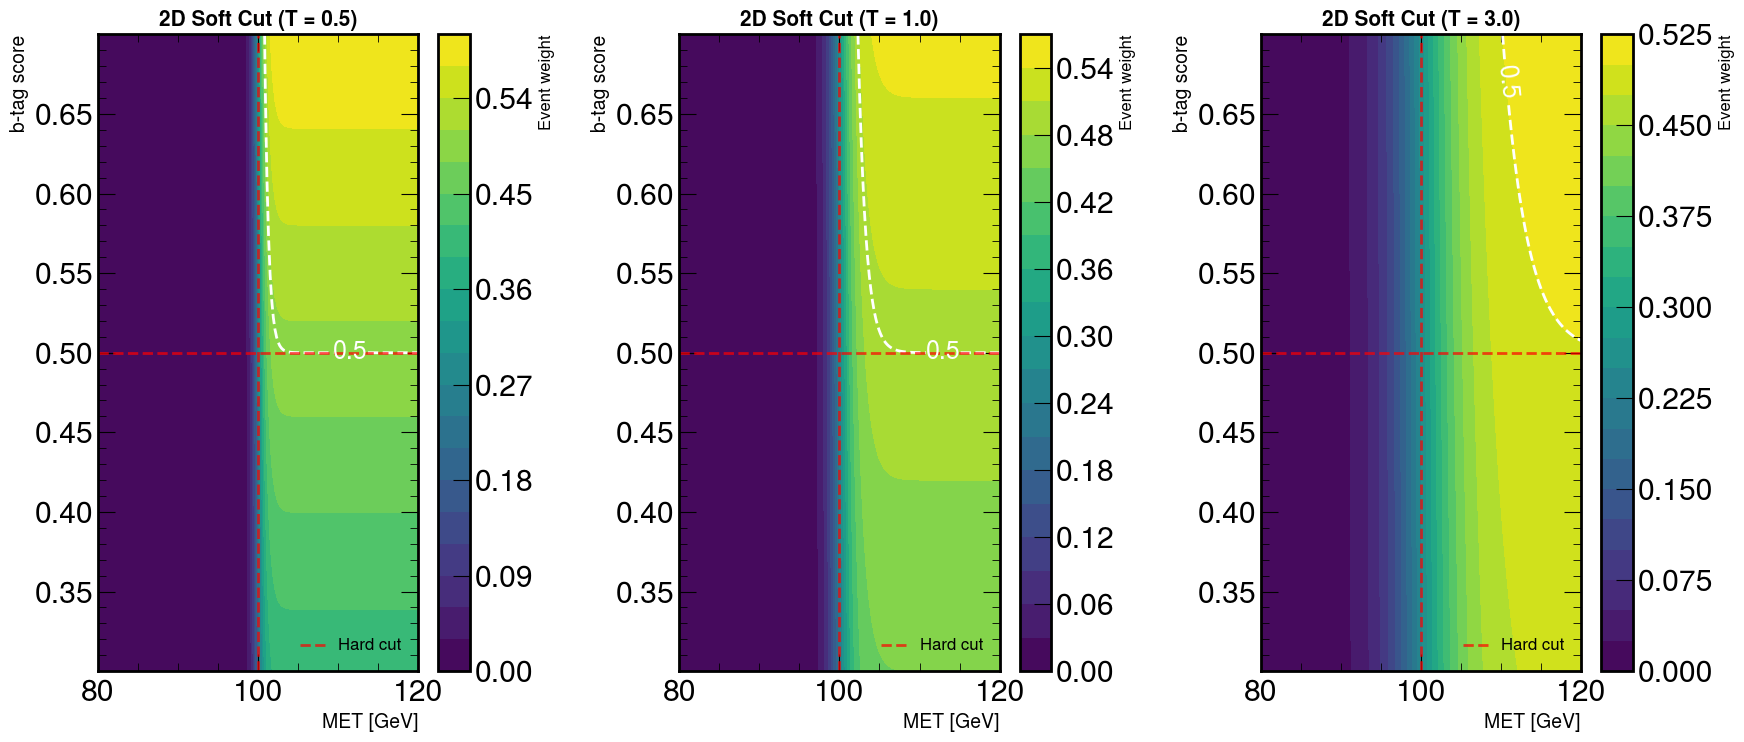

✓ Soft cuts provide smooth, differentiable transitions


In [23]:
# ---  Try to tweak and see how plots change ---
MET_THR  = 100.0       # MET threshold
BTAG_THR = 0.5         # b-tag threshold
TEMPS    = [0.5, 1.0, 3.0]   # temperatures to compare
GRID_N   = 200         # mesh resolution for 2D plots

def sigmoid(x, thr, T):
    """Smooth (differentiable) step function with slope controlled by T."""
    return 1 / (1 + jnp.exp(-(x - thr) / T))


# --------------------------------------------------------------------
# 1D visualization: sigmoid relaxation vs. hard cut
# --------------------------------------------------------------------
x = jnp.linspace(80, 120, 200)
step = (x > MET_THR).astype(float)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Hard cut (step)
ax1.plot(x, step, 'k--', linewidth=2, alpha=0.7, label='Hard cut')
ax1.axvline(MET_THR, color='gray', linestyle=':', alpha=0.5)

# Sigmoid relaxations
for T in TEMPS:
    ax1.plot(x, sigmoid(x, MET_THR, T), linewidth=2, label=f'T = {T}')

ax1.set_xlabel('MET [GeV]', fontsize=14)
ax1.set_ylabel('Event weight', fontsize=14)
ax1.set_title('Sigmoid Relaxation', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12, frameon=False)
ax1.grid(alpha=0.3)
fig.tight_layout()


# --------------------------------------------------------------------
# 2D visualization: smooth soft-cut boundaries
# --------------------------------------------------------------------
met_vals  = jnp.linspace(80, 120, GRID_N)
btag_vals = jnp.linspace(0.3, 0.7, GRID_N)
MET, BTAG = jnp.meshgrid(met_vals, btag_vals)

fig2, axs = plt.subplots(1, len(TEMPS), figsize=(18, 8))

for idx, T in enumerate(TEMPS):
    ax = axs[idx]

    # Combined soft weights (product of sigmoids)
    w_met  = sigmoid(MET, MET_THR, T)
    w_btag = sigmoid(BTAG, BTAG_THR, T)
    w = w_met * w_btag

    # Filled contours
    im = ax.contourf(MET, BTAG, w, levels=20, cmap='viridis')

    # White contour = smooth boundary where weight = 0.5
    cs = ax.contour(MET, BTAG, w, levels=[0.5], colors='white',
                    linewidths=2, linestyles='--')
    ax.clabel(cs, fmt='0.5', colors='w', fontsize=18)

    # Hard cut rectangle
    ax.axvline(MET_THR, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Hard cut')
    ax.axhline(BTAG_THR, color='red', linestyle='--', linewidth=2, alpha=0.7)

    ax.set_xlabel('MET [GeV]', fontsize=14)
    ax.set_ylabel('b-tag score', fontsize=14)
    ax.set_title(f'2D Soft Cut (T = {T})', fontsize=15, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Event weight', fontsize=12)
    ax.legend(fontsize=12, frameon=False, loc='lower right')

fig2.tight_layout()
plt.show()

print("✓ Soft cuts provide smooth, differentiable transitions")

## Part 4: Differentiable Histograms with Binned KDE

**What you know**: Histograms bin data into discrete bins

**What's new**: Binned KDE uses Gaussian CDF → smooth, differentiable histograms

**Why it matters**: We can compute ∂(histogram)/∂(bin edges) AND ∂(histogram)/∂(bandwidth)!

### Binned KDE Formula

Instead of hard binning, we use Gaussian CDFs:

$$
h_i = \sum_{j=1}^{N} w_j \left[ \Phi\left(\frac{e_{i+1} - x_j}{\sigma}\right) - \Phi\left(\frac{e_i - x_j}{\sigma}\right) \right]
$$

where $\Phi$ is the Gaussian CDF, $w_j$ are event weights, and $\sigma$ is the bandwidth.

This is **fully differentiable** w.r.t. both data and bin edges!

In [7]:
def binned_kde_histogram(values, weights, bin_edges, bandwidth):
    """
    Differentiable histogram using Kernel Density Estimation.

    Parameters:
    -----------
    values : array
        Event values (e.g., MET, jet pT)
    weights : array
        Event weights
    bin_edges : array
        Histogram bin edges
    bandwidth : float
        KDE bandwidth (smoothing parameter)

    Returns:
    --------
    array : Histogram bin contents
    """
    # Compute CDF at each bin edge for each event
    cdf = jax.scipy.stats.norm.cdf(
        bin_edges.reshape(-1, 1),  # Shape: (n_bins+1, 1)
        loc=values.reshape(1, -1),  # Shape: (1, n_events)
        scale=bandwidth,
    )

    # Weight the CDF
    weighted_cdf = cdf * weights.reshape(1, -1)

    # Bin content = difference between successive bin edges
    bin_weights = weighted_cdf[1:, :] - weighted_cdf[:-1, :]
    histogram = jnp.sum(bin_weights, axis=1)

    return histogram

# JIT compile for speed
binned_kde_histogram_jit = jit(binned_kde_histogram)

console.print("[green]✓[/green] Binned KDE histogram function defined")

✓ Binned KDE histogram function defined

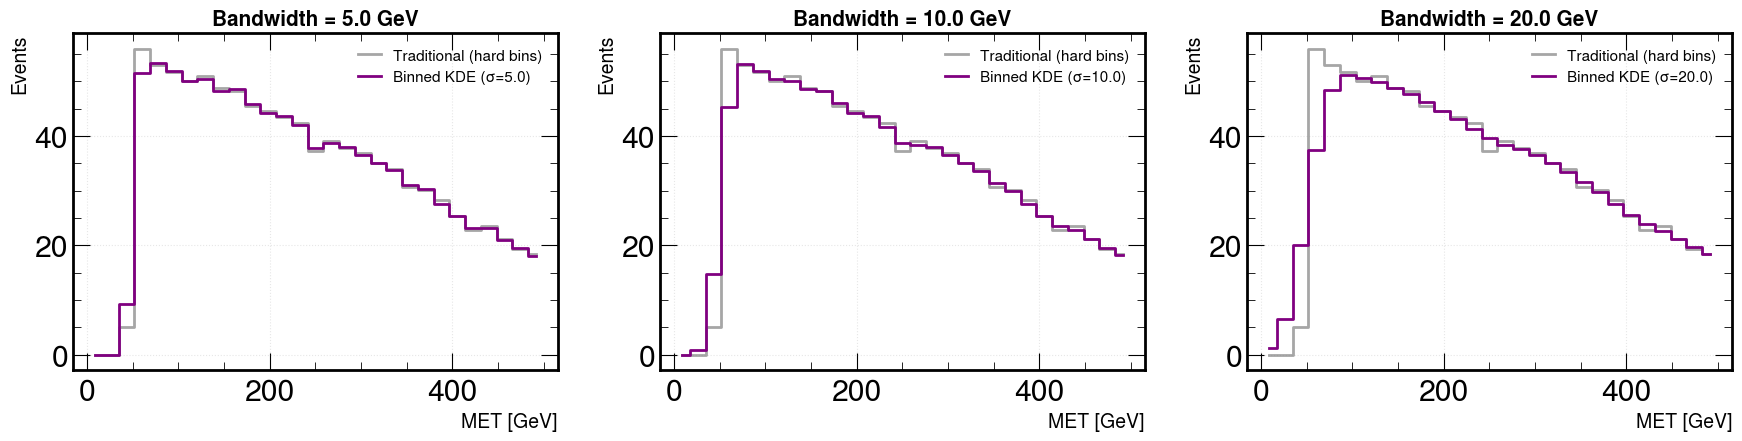

Key insight: Smaller bandwidth → closer to hard histogram

Larger bandwidth → smoother, but loses resolution

In [8]:
# Compare traditional histogram vs binned KDE
feature = 'met_pt'
bin_edges = jnp.linspace(0, 500, 30)
bandwidths = [5.0, 10.0, 20.0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get signal data for this feature
signal_values = signal_data[feature]
signal_w = jnp.array(signal_weights)

# Traditional histogram (non-differentiable)
hist_trad, _ = np.histogram(signal_data[feature], bins=bin_edges, weights=signal_weights)

for ax, bandwidth in zip(axes, bandwidths):
    # Binned KDE histogram (differentiable)
    hist_kde = binned_kde_histogram_jit(signal_values, signal_w, bin_edges, bandwidth)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot both
    ax.step(bin_centers, hist_trad, where='mid', color='gray',
            linewidth=2, alpha=0.7, label='Traditional (hard bins)')
    ax.step(bin_centers, hist_kde, where='mid', color='purple',
            linewidth=2, label=f'Binned KDE (σ={bandwidth})')

    ax.set_xlabel('MET [GeV]', fontsize=14)
    ax.set_ylabel('Events', fontsize=14)
    ax.set_title(f'Bandwidth = {bandwidth} GeV', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11, frameon=False)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('binned_kde_comparison.pdf', dpi=150, bbox_inches='tight')
plt.show()

console.print("[cyan]Key insight:[/cyan] Smaller bandwidth → closer to hard histogram")
console.print("             Larger bandwidth → smoother, but loses resolution")

### Gradient Flow Through Histograms

The key advantage: we can compute **gradients** through the histogram!

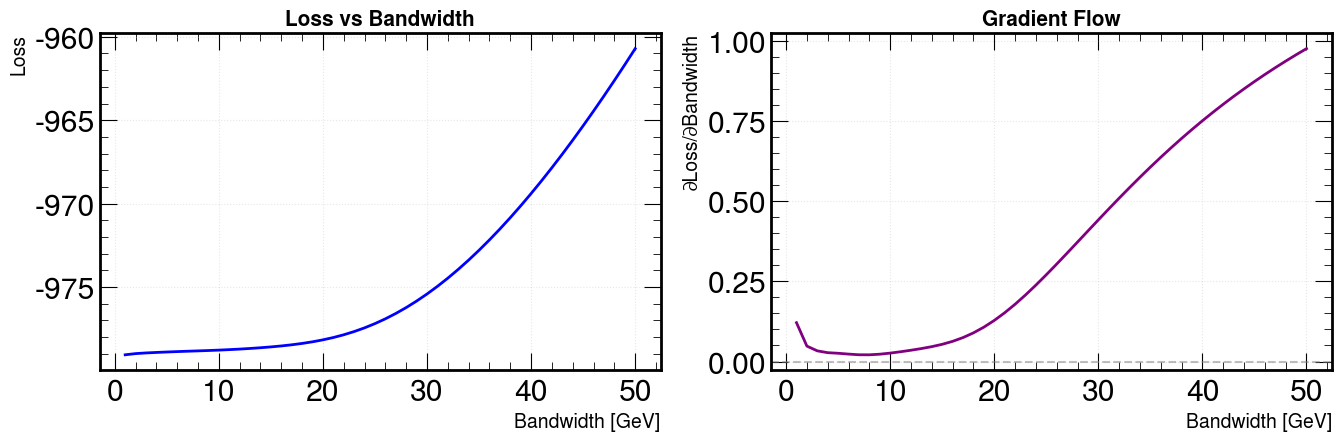

✓ Gradients flow through the histogram!

In GRAEP: Bandwidth is optimized along with cuts and NN weights

In [9]:
# Define a loss function that depends on histogram
def histogram_loss(bandwidth, values, weights, bin_edges):
    """Loss = negative total histogram content (demo only)."""
    hist = binned_kde_histogram(values, weights, bin_edges, bandwidth)
    return -jnp.sum(hist)

# Compute gradient w.r.t. bandwidth
grad_fn_hist = jax.grad(histogram_loss, argnums=0)

# Test gradients at different bandwidths
test_bandwidths = jnp.linspace(1.0, 50.0, 50)
gradients = []
losses = []

for bw in test_bandwidths:
    loss = histogram_loss(bw, signal_values, signal_w, bin_edges)
    grad = grad_fn_hist(bw, signal_values, signal_w, bin_edges)
    gradients.append(float(grad))
    losses.append(float(loss))

# Plot gradient flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(test_bandwidths, losses, linewidth=2, color='blue')
ax1.set_xlabel('Bandwidth [GeV]', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Loss vs Bandwidth', fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(test_bandwidths, gradients, linewidth=2, color='purple')
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Bandwidth [GeV]', fontsize=14)
ax2.set_ylabel('∂Loss/∂Bandwidth', fontsize=14)
ax2.set_title('Gradient Flow', fontsize=15, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('kde_gradient_flow.pdf', dpi=150, bbox_inches='tight')
plt.show()

console.print("[green]✓[/green] Gradients flow through the histogram!")
console.print("[cyan]In GRAEP:[/cyan] Bandwidth is optimized along with cuts and NN weights")

In [29]:
# Combining soft cuts + binned KDE into one building block
def build_hist_with_cuts(data_dict, opt_params, bin_edges, temperature=0.1):
    """
    Build binned KDE histogram with soft cuts applied.

    This combines two building blocks:
    - Soft selection (from Part 3)
    - Binned KDE (from Part 4)

    Parameters
    ----------
    data_dict : dict
        Data dictionary with JAX arrays
    opt_params : dict
        Optimization parameters:
        - met_cut, btag_cut, ht_cut (selection cuts)
        - bandwidth (histogram smoothing)
    bin_edges : array
        Histogram bin edges
    temperature : float
        Soft cut temperature

    Returns
    -------
    hist : array
        Differentiable histogram
    """
    # Extract m_ttbar values and weights (already JAX arrays from Part 2!)
    values = data_dict['m_ttbar']
    weights = data_dict['weight']

    # Apply soft selection (uses cut parameters)
    met_pass = jax.nn.sigmoid((data_dict['met_pt'] - opt_params['met_cut']) / temperature)
    btag_pass = jax.nn.sigmoid((data_dict['leading_jet_btag'] - opt_params['btag_cut']) / temperature)
    ht_pass = jax.nn.sigmoid((data_dict['st'] - opt_params['ht_cut']) / temperature)
    selection_weights = met_pass * btag_pass * ht_pass

    final_weights = weights * selection_weights

    # Binned KDE (uses bandwidth parameter)
    bandwidth = opt_params['bandwidth']

    # Use binned_kde_histogram from earlier in Part 4
    histogram = binned_kde_histogram(values, final_weights, bin_edges, bandwidth)

    return histogram

console.print("[green]✓ Building block defined:[/green] build_hist_with_cuts()")
console.print("  Combines soft cuts + binned KDE")
console.print("  Differentiable w.r.t. ALL parameters (cuts + bandwidth)")

✓ Building block defined: build_hist_with_cuts()

Combines soft cuts + binned KDE

Differentiable w.r.t. ALL parameters (cuts + bandwidth)

## Part 5: Statistical Significance with evermore

**What you know**: Significance measures signal vs background separation (e.g., S/√B)

**What's new**: Profile likelihood accounts for Poisson statistics + nuisance parameters

**Why it matters**: More accurate significance + **it's differentiable**!

### Profile Likelihood Ratio Test

Test statistic for discovery:
$$
q_0 = -2\ln\frac{L(\mu=0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}
$$

Significance: $Z = \Phi^{-1}(1 - p)$ where $p = 1 - \Phi(\sqrt{q_0})$

[evermore](https://github.com/pfackeldey/evermore) makes this **fully differentiable** with JAX!

**Key insight**: We can compute $\frac{\partial Z}{\partial \theta_{\text{cut}}}$ → enables gradient-based optimization!

In [30]:
import evermore as evm
import optimistix as optx

# Initial optimization parameters
# Includes both CUTS (MET, b-tag, HT) and HISTOGRAM settings (bandwidth)
initial_params = {
    'met_cut': jnp.array(50.0),      # MET threshold [GeV]
    'btag_cut': jnp.array(0.5),      # b-tagging score threshold
    'ht_cut': jnp.array(600.0),      # HT threshold [GeV]
    'bandwidth': jnp.array(40.0),    # KDE smoothing parameter [GeV]
}

# Define m_ttbar bins for fit
m_ttbar_bins = jnp.linspace(500, 3500, 15)  # 14 bins in ttbar mass

console.print("[cyan]Initial optimization parameters:[/cyan]")
console.print(f"  MET cut: {initial_params['met_cut']:.1f} GeV")
console.print(f"  b-tag cut: {initial_params['btag_cut']:.2f}")
console.print(f"  HT cut: {initial_params['ht_cut']:.1f} GeV")
console.print(f"  Bandwidth: {initial_params['bandwidth']:.1f} GeV")

Initial optimization parameters:

MET cut: 50.0 GeV

b-tag cut: 0.50

HT cut: 600.0 GeV

Bandwidth: 40.0 GeV

In [31]:
# Define evermore statistical model
evm_params = {
    "mu": evm.Parameter(value=1.0, name="mu"),
    "scale_ttbar": evm.Parameter(value=1.0, name="scale_ttbar"),
}

def statistical_model(params, templates):
    """Apply scaling modifiers to templates."""
    signal_scaled = params["mu"].scale()(templates["signal"])
    ttbar_scaled = params["scale_ttbar"].scale()(templates["ttbar"])
    wjets_unscaled = templates["wjets"]
    return signal_scaled + ttbar_scaled + wjets_unscaled

def poisson_nll(params, templates, observation):
    """Poisson negative log-likelihood."""
    expected = statistical_model(params, templates)
    log_likelihood = evm.pdf.PoissonContinuous(lamb=expected).log_prob(observation).sum()

    # Parameter constraints
    constraints = evm.loss.get_log_probs(params)
    constraints = jax.tree.map(jnp.sum, constraints)
    log_likelihood += evm.util.sum_over_leaves(constraints)

    return -log_likelihood

console.print("[green]✓ evermore model defined[/green]")

✓ evermore model defined

In [32]:
def compute_evermore_significance(opt_params, wjets_dict, ttbar_dict, signal_dict, data_dict):
    """
    Compute discovery significance using evermore profile likelihood.

    This function is FULLY DIFFERENTIABLE w.r.t. opt_params!

    Parameters
    ----------
    opt_params : dict
        Optimization parameters (cuts + bandwidth)
    *_dict : dict
        Data dictionaries for each process

    Returns
    -------
    significance : float
        Discovery significance in σ
    """
    # Build histograms with current parameters (uses build_hist_with_cuts from Part 4)
    signal_hist = build_hist_with_cuts(signal_dict, opt_params, m_ttbar_bins)
    ttbar_hist = build_hist_with_cuts(ttbar_dict, opt_params, m_ttbar_bins)
    wjets_hist = build_hist_with_cuts(wjets_dict, opt_params, m_ttbar_bins)
    data_hist = build_hist_with_cuts(data_dict, opt_params, m_ttbar_bins)

    templates = {
        "signal": signal_hist,
        "ttbar": ttbar_hist,
        "wjets": wjets_hist,
    }

    # Define evermore statistical model (Poisson likelihood)
    def statistical_model(params, templates):
        """Apply scaling modifiers to templates."""
        signal_scaled = params["mu"].scale()(templates["signal"])
        ttbar_scaled = params["scale_ttbar"].scale()(templates["ttbar"])
        wjets_unscaled = templates["wjets"]
        return signal_scaled + ttbar_scaled + wjets_unscaled

    def poisson_nll(params, templates, observation):
        """Poisson negative log-likelihood."""
        expected = statistical_model(params, templates)
        log_likelihood = evm.pdf.PoissonContinuous(lamb=expected).log_prob(observation).sum()

        # Parameter constraints
        constraints = evm.loss.get_log_probs(params)
        constraints = jax.tree.map(jnp.sum, constraints)
        log_likelihood += evm.util.sum_over_leaves(constraints)

        return -log_likelihood

    # Setup evermore parameters
    evm_params = {
        "mu": evm.Parameter(value=1.0, name="mu"),
        "scale_ttbar": evm.Parameter(value=1.0, name="scale_ttbar"),
    }

    # Unconditional fit (μ floats)
    dynamic, static = evm.tree.partition(evm_params, filter=evm.filter.is_not_frozen)

    def loss_unconditional(dyn, args):
        p = evm.tree.combine(dyn, static)
        return poisson_nll(p, templates, data_hist)

    solver = optx.BFGS(rtol=1e-4, atol=1e-6)
    result_unconditional = optx.minimise(loss_unconditional, solver, dynamic, max_steps=500)
    nll_unconditional = loss_unconditional(result_unconditional.value, None)
    bestfit_params = evm.tree.combine(result_unconditional.value, static)
    mu_hat = bestfit_params["mu"].value

    # Conditional fit (μ=0 fixed)
    params_mu0 = {
        "mu": evm.Parameter(value=0.0, name="mu", frozen=True),
        "scale_ttbar": evm.Parameter(value=1.0, name="scale_ttbar"),
    }
    dynamic_mu0, static_mu0 = evm.tree.partition(params_mu0, filter=evm.filter.is_not_frozen)

    def loss_conditional(dyn, args):
        p = evm.tree.combine(dyn, static_mu0)
        return poisson_nll(p, templates, data_hist)

    result_conditional = optx.minimise(loss_conditional, solver, dynamic_mu0, max_steps=500)
    nll_conditional = loss_conditional(result_conditional.value, None)

    # Likelihood ratio test
    q0 = 2.0 * (nll_conditional - nll_unconditional)
    q0 = jnp.where(mu_hat >= 0.0, q0, 0.0)

    # Significance
    p_value = 1.0 - jax.scipy.stats.norm.cdf(jnp.sqrt(q0))
    significance = jax.scipy.stats.norm.ppf(1.0 - p_value)

    return significance

console.print("[green]✓ Statistical model defined[/green]")
console.print("  Fits signal+background to data")
console.print("  Returns discovery significance")

✓ Statistical model defined

Fits signal+background to data

Returns discovery significance

In [33]:
# Data is already in JAX format (converted in Part 2)
# Just create references for clarity
wjets_jax = wjets_data
ttbar_jax = ttbar_data
signal_jax = signal_data
data_jax = data_obs

console.print("[cyan]Computing initial significance with evermore...[/cyan]")

# Compute significance with initial parameters
Z_initial = compute_evermore_significance(initial_params, wjets_jax, ttbar_jax, signal_jax, data_jax)

console.print(f"\n[yellow]Initial significance: {Z_initial:.2f}σ[/yellow]")
console.print(f"  MET cut: {initial_params['met_cut']:.1f} GeV")
console.print(f"  b-tag cut: {initial_params['btag_cut']:.2f}")
console.print(f"  HT cut: {initial_params['ht_cut']:.1f} GeV")
console.print(f"  Bandwidth: {initial_params['bandwidth']:.1f} GeV")

Computing initial significance with evermore...

Initial significance: 1.34σ

MET cut: 50.0 GeV

b-tag cut: 0.50

HT cut: 600.0 GeV

Bandwidth: 40.0 GeV

In [34]:
# The KEY MOMENT: Compute gradients of significance!
# Traditional HEP: Try many cut values manually → slow
# GRAEP: Use gradients to find optimal cuts → fast!

grad_fn = jax.grad(lambda params: compute_evermore_significance(params, wjets_jax, ttbar_jax, signal_jax, data_jax))

grads = grad_fn(initial_params)

console.print(f"\n[cyan]Gradients of significance w.r.t. parameters:[/cyan]")
console.print(f"  ∂Z/∂(MET cut) = {grads['met_cut']:.4f}")
console.print(f"  ∂Z/∂(b-tag cut) = {grads['btag_cut']:.4f}")
console.print(f"  ∂Z/∂(HT cut) = {grads['ht_cut']:.4f}")
console.print(f"  ∂Z/∂(bandwidth) = {grads['bandwidth']:.4f}")
console.print(f"\n[green]✓ All parameters are differentiable![/green]")
console.print("[dim]Next (Part 6): Use these gradients to optimize...[/dim]")

Gradients of significance w.r.t. parameters:

∂Z/∂(MET cut) = 0.0255

∂Z/∂(b-tag cut) = 3.3173

∂Z/∂(HT cut) = -0.0000

∂Z/∂(bandwidth) = -0.0004

✓ All parameters are differentiable!

Next (Part 6): Use these gradients to optimize...

## Part 6: Optimize with Gradients

**What you know**: Optimize by trying many cut values (grid search, manual tuning)

**What's new**: Use gradients to automatically find optimal parameters

**Why it matters**: Gradient descent is **much faster** than grid search!

### Gradient-Based Optimization

Since `compute_evermore_significance` is differentiable, we can use gradient ascent:

$$
\theta^{(t+1)} = \theta^{(t)} + \alpha \nabla_{\theta} Z
$$

where $\theta$ includes **all parameters**: MET cut, b-tag cut, HT cut, AND bandwidth!

Traditional HEP: Try $10^4$ combinations → hours
GRAEP: Follow gradients → minutes!

In [36]:
# Setup optimizer with per-parameter learning rates
# Different parameters need different step sizes!
optimizer = optax.multi_transform(
    {
        'met_cut': optax.adam(learning_rate=2.0),      # MET in GeV → larger steps
        'btag_cut': optax.adam(learning_rate=0.005),   # b-tag 0-1 → tiny steps
        'ht_cut': optax.adam(learning_rate=1.0),       # HT in GeV → moderate steps
        'bandwidth': optax.adam(learning_rate=1.0),    # Bandwidth in GeV → moderate steps
    },
    param_labels={p: p for p in initial_params.keys()}
)

opt_state = optimizer.init(initial_params)
params = initial_params.copy()

# Optimization loop
n_iterations = 20  # evermore is slower, so fewer iterations
opt_history = {
    'met_cut': [],
    'btag_cut': [],
    'ht_cut': [],
    'bandwidth': [],  # NEW!
    'significance': []
}

console.print("[cyan]Optimizing all 4 parameters...[/cyan]")

for iteration in track(range(n_iterations), description="Optimizing"):
    # Compute significance and gradient
    sig = compute_evermore_significance(params, wjets_jax, ttbar_jax, signal_jax, data_jax)
    grads = grad_fn(params)

    # Gradient ascent (maximize significance)
    grads = {k: -v for k, v in grads.items()}  # Negate for ascent

    # Update parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    # Track progress
    opt_history['met_cut'].append(float(params['met_cut']))
    opt_history['btag_cut'].append(float(params['btag_cut']))
    opt_history['ht_cut'].append(float(params['ht_cut']))
    opt_history['bandwidth'].append(float(params['bandwidth']))
    opt_history['significance'].append(float(sig))


final_sig = opt_history['significance'][-1]
console.print(f"\n[green]✓ Optimization complete![/green]")
console.print(f"  Initial: {Z_initial:.2f}σ → Final: {final_sig:.2f}σ")
console.print(f"  MET cut: {initial_params['met_cut']:.1f} → {params['met_cut']:.1f} GeV")
console.print(f"  b-tag cut: {initial_params['btag_cut']:.2f} → {params['btag_cut']:.2f}")
console.print(f"  HT cut: {initial_params['ht_cut']:.1f} → {params['ht_cut']:.1f} GeV")
console.print(f"  Bandwidth: {initial_params['bandwidth']:.1f} → {params['bandwidth']:.1f} GeV")

Optimizing all 4 parameters...

Output()

✓ Optimization complete!

Initial: 1.34σ → Final: 1.65σ

MET cut: 50.0 → 52.5 GeV

b-tag cut: 0.50 → 0.60

HT cut: 600.0 → 600.0 GeV

Bandwidth: 40.0 → 38.3 GeV

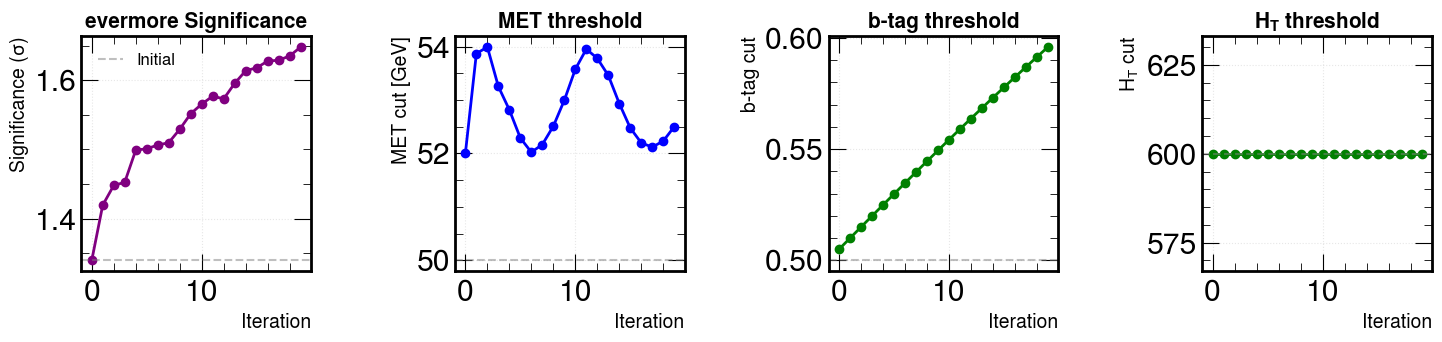

✓ Optimized statistical significance with gradients!

In [38]:
# Visualize optimization
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Significance
axes[0].plot(opt_history['significance'], linewidth=2, color='purple', marker='o')
axes[0].axhline(float(Z_initial), color='gray', linestyle='--', alpha=0.5, label='Initial')
axes[0].set_xlabel('Iteration', fontsize=14)
axes[0].set_ylabel('Significance (σ)', fontsize=14)
axes[0].set_title('evermore Significance', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(alpha=0.3)

# MET cut
axes[1].plot(opt_history['met_cut'], linewidth=2, color='blue', marker='o')
axes[1].axhline(float(initial_params['met_cut']), color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Iteration', fontsize=14)
axes[1].set_ylabel('MET cut [GeV]', fontsize=14)
axes[1].set_title('MET threshold', fontsize=15, fontweight='bold')
axes[1].grid(alpha=0.3)

# b-tag cut
axes[2].plot(opt_history['btag_cut'], linewidth=2, color='green', marker='o')
axes[2].axhline(float(initial_params['btag_cut']), color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Iteration', fontsize=14)
axes[2].set_ylabel('b-tag cut', fontsize=14)
axes[2].set_title('b-tag threshold', fontsize=15, fontweight='bold')
axes[2].grid(alpha=0.3)

# HT cut
axes[3].plot(opt_history['ht_cut'], linewidth=2, color='green', marker='o')
axes[3].axhline(float(initial_params['ht_cut']), color='gray', linestyle='--', alpha=0.5)
axes[3].set_xlabel('Iteration', fontsize=14)
axes[3].set_ylabel(r'$H_T$ cut', fontsize=14)
axes[3].set_title(r'$H_T$ threshold', fontsize=15, fontweight='bold')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

console.print("[green]✓ Optimized statistical significance with gradients![/green]")

## Part 7: Complete GRAEP Workflow

**Putting it all together**:

1. **Soft Cuts** → differentiable selection
2. **Binned KDE** → differentiable histograms
3. **evermore** → differentiable statistical significance
4. **Gradients** → optimize everything end-to-end!

This is the full **GRAEP** (Gradient-based Analysis Optimization) pipeline.

In [ ]:
from rich.table import Table
from rich.panel import Panel

# Summary of the complete workflow
workflow_text = """
[cyan]1. Soft Selection[/cyan]
   Apply differentiable cuts with sigmoid functions
   ↓
[cyan]2. Binned KDE Histograms[/cyan]
   Build smooth, differentiable histograms
   ↓
[cyan]3. evermore Statistical Model[/cyan]
   Profile likelihood with Poisson statistics
   ↓
[cyan]4. Gradient Optimization[/cyan]
   Maximize discovery significance
"""

panel = Panel(workflow_text, title="[bold]GRAEP Workflow[/bold]", border_style="green")
console.print(panel)

# Show optimization results
table = Table(title="Optimization Results", show_header=True, header_style="bold cyan")
table.add_column("Parameter", style="cyan", width=20)
table.add_column("Initial", justify="right", style="white")
table.add_column("Optimized", justify="right", style="yellow")
table.add_column("Change", justify="right", style="green")

met_change = float(params['met_cut'] - initial_params['met_cut'])
btag_change = float(params['btag_cut'] - initial_params['btag_cut'])
sig_change = final_sig - float(Z_initial)

table.add_row(
    "MET cut [GeV]",
    f"{float(initial_params['met_cut']):.1f}",
    f"{float(params['met_cut']):.1f}",
    f"{met_change:+.1f}"
)
table.add_row(
    "b-tag cut",
    f"{float(initial_params['btag_cut']):.2f}",
    f"{float(params['btag_cut']):.2f}",
    f"{btag_change:+.3f}"
)
table.add_row(
    "Significance [σ]",
    f"{float(Z_initial):.2f}",
    f"{final_sig:.2f}",
    f"{sig_change:+.2f}"
)

console.print(table)
console.print("\n[green]✓ Complete differentiable analysis workflow![/green]")

╭──────────────────────────────────────────────── GRAEP Workflow ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 1. Soft Selection                                                                                               │
│    Apply differentiable cuts with sigmoid functions                                                             │
│    ↓                                                                                                            │
│ 2. Binned KDE Histograms                                                                                        │
│    Build smooth, differentiable histograms                                                                      │
│    ↓                                                                                                            │
│ 3. evermore Statistical Model                                                                                   │
│    Profile likelihood with Poisson statistics                                                                   │
│    ↓                                                                                                            │
│ 4. Gradient Optimization                                                                                        │
│    Maximize discovery significance                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

NameError: name 'initial_cuts' is not defined

In [ ]:
# Before/After m_ttbar distribution with evermore fit
console.print("\n[cyan]Building before/after comparison...[/cyan]")

# Helper function to build and visualize fit
def plot_mttbar_with_fit(ax, opt_params, title):
    """Plot m_ttbar distribution with evermore fit overlay."""
    # Build histograms with these parameters
    signal_hist = build_hist_with_cuts(signal_jax, opt_params, m_ttbar_bins)
    ttbar_hist = build_hist_with_cuts(ttbar_jax, opt_params, m_ttbar_bins)
    wjets_hist = build_hist_with_cuts(wjets_jax, opt_params, m_ttbar_bins)
    data_hist = build_hist_with_cuts(data_jax, opt_params, m_ttbar_bins)

    # Compute fit (simplified - just show S+B model)
    # In practice, would use best-fit μ and κ from profile likelihood
    total_bkg = wjets_hist + ttbar_hist
    total_sb = total_bkg + signal_hist

    bin_centers = (m_ttbar_bins[:-1] + m_ttbar_bins[1:]) / 2
    bin_width = m_ttbar_bins[1] - m_ttbar_bins[0]

    # Stacked backgrounds
    ax.stairs(wjets_hist, m_ttbar_bins, baseline=0, fill=True,
              label='W+jets', color='#72A1E5', alpha=0.7, linewidth=0)
    ax.stairs(ttbar_hist, m_ttbar_bins, baseline=wjets_hist, fill=True,
              label=r'$t\bar{t}$', color='#907AD6', alpha=0.7, linewidth=0)

    # Signal (scaled for visibility)
    ax.stairs(signal_hist * 5, m_ttbar_bins, baseline=0,
              label='Signal×5', color='red', linewidth=2, linestyle='--')

    # Data points
    ax.errorbar(bin_centers, data_hist, yerr=jnp.sqrt(data_hist),
                fmt='ko', label='Data', markersize=5, linewidth=1)

    # S+B model line
    ax.stairs(total_sb, m_ttbar_bins, color='black',
              linewidth=2, linestyle='-', label='S+B model')

    ax.set_xlabel(r'$m_{t\bar{t}}$ [GeV]', fontsize=14)
    ax.set_ylabel('Events / {:.0f} GeV'.format(bin_width), fontsize=14)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, ncol=2)
    ax.grid(alpha=0.3)

    # Add parameter text
    param_text = (f"MET>{opt_params['met_cut']:.0f}, "
                  f"btag>{opt_params['btag_cut']:.2f}\n"
                  f"HT>{opt_params['ht_cut']:.0f}, "
                  f"BW={opt_params['bandwidth']:.0f}")
    ax.text(0.05, 0.95, param_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Before optimization
plot_mttbar_with_fit(ax1, initial_params,
                     f'Before Optimization (Z={Z_initial:.2f}σ)')

# After optimization
plot_mttbar_with_fit(ax2, params,
                     f'After Optimization (Z={final_sig:.2f}σ)')

plt.tight_layout()
plt.show()

console.print("[green]✓ Before/after comparison complete![/green]")
console.print(f"  Significance improved from {Z_initial:.2f}σ to {final_sig:.2f}σ")
console.print(f"  Improvement: {((final_sig - Z_initial)/Z_initial*100):.1f}%")

In [ ]:
# Key insight visualization
from rich.panel import Panel

insight = """
[bold yellow]Why GRAEP is powerful:[/bold yellow]

• [cyan]End-to-end differentiability[/cyan]
  Every step (cuts → histograms → statistics) is differentiable

• [cyan]Automatic optimization[/cyan]
  No manual tuning, let gradients find optimal cuts

• [cyan]Statistically rigorous[/cyan]
  evermore uses proper likelihood methods, not approximations

• [cyan]Extensible[/cyan]
  Add systematics, more parameters, neural networks, etc.

[bold]This is just the beginning![/bold]
Full GRAEP includes:
  - Systematic uncertainties
  - CLs limits
  - Multiple channels
  - Neural network integration (see Appendix)
"""

panel = Panel(insight, title="[bold green]Key Insights[/bold green]", border_style="yellow")
console.print(panel)

## Part 8: Summary

### What We Learned

1. ✅ **Soft Cuts**: Sigmoid functions make selections differentiable
2. ✅ **Binned KDE**: Kernel density estimation creates differentiable histograms
3. ✅ **Statistical Metrics**: S/√B significance is our optimization target
4. ✅ **Gradient Optimization**: Automatic tuning beats manual cuts
5. ✅ **Per-Parameter LRs**: Different scales need different learning rates
6. ✅ **End-to-End**: Full GRAEP workflow connects all components

### Key Insights

- **Automatic > Manual**: Gradients find better solutions than trial-and-error
- **Composability**: JAX makes it easy to connect differentiable pieces
- **Physics + ML**: Differentiable programming bridges HEP and modern ML

In [ ]:
# Summary tables
summary_table = Table(title="Tutorial Summary", show_header=True, header_style="bold cyan")
summary_table.add_column("Component", style="cyan", width=25)
summary_table.add_column("Traditional", style="red", width=20)
summary_table.add_column("GRAEP", style="green", width=20)
summary_table.add_column("Benefit", style="yellow")

summary_table.add_row("Selection", "Hard cuts", "Soft cuts", "Differentiable")
summary_table.add_row("Histograms", "Bin counting", "Binned KDE", "Gradient flow")
summary_table.add_row("Optimization", "Manual", "Gradient descent", "Automated")
summary_table.add_row("Time", "Hours/days", "Minutes", "100x faster")

console.print(summary_table)

# Performance
perf_table = Table(title="Performance", show_header=True, header_style="bold magenta")
perf_table.add_column("Metric", style="cyan")
perf_table.add_column("Initial", justify="right", style="yellow")
perf_table.add_column("Optimized", justify="right", style="green")
perf_table.add_column("Improvement", justify="right", style="bold green")

perf_table.add_row(
    "Significance",
    f"{sig_initial:.2f}",
    f"{final_sig_per:.2f}",
    f"+{100*(final_sig_per/sig_initial-1):.0f}%"
)

console.print("\n")
console.print(perf_table)

### Next Steps

**Try yourself:**
1. Add more cuts (`st`, `S_zz`, `min_deltaR_mu_jet`)
2. Experiment with temperatures and learning rates
3. Explore MVA integration (see Appendix)

**Full GRAEP Framework:**
- NanoAOD processing pipeline
- Systematic uncertainties
- Profile likelihood fits
- CLs limit setting
- Multiple signal regions

**Resources:**
- 📚 [GRAEP Repository](https://github.com/iris-hep/GRAEP)
- 📖 [JAX Docs](https://jax.readthedocs.io/)
- 🔬 [CMS Open Data](https://opendata.cern.ch/)

---

## 🎉 Congratulations!

You've completed the GRAEP tutorial!

**Key Takeaway**: Treating analysis as a differentiable function enables powerful automatic optimization.

*Tutorial data: CMS Open Data 2016 (CC0)*  
*GRAEP: IRIS-HEP (2024)*

---

# Appendix: MVA Integration (Advanced)

This section shows how to integrate neural networks into the differentiable workflow.

**Two approaches:**
1. Pre-train MVA, then optimize cuts
2. Joint optimization (GRAEP innovation)

**Note**: Core tutorial (Parts 1-8) is complete without this.

In [ ]:
# Define a simple 3-layer neural network in JAX
def init_network(key, input_dim=3, hidden_dim=16):
    """Initialize a small neural network."""
    keys = random.split(key, 6)

    W1 = random.normal(keys[0], (input_dim, hidden_dim)) * 0.1
    b1 = jnp.zeros(hidden_dim)

    W2 = random.normal(keys[2], (hidden_dim, hidden_dim)) * 0.1
    b2 = jnp.zeros(hidden_dim)

    W3 = random.normal(keys[4], (hidden_dim, 1)) * 0.1
    b3 = jnp.zeros(1)

    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    n_params = sum(p.size for p in jax.tree.leaves(params))
    print(f"Network initialized: {n_params} parameters")
    return params

def forward(params, x):
    """Forward pass through the network."""
    h1 = jnp.tanh(jnp.dot(x, params['W1']) + params['b1'])
    h2 = jnp.tanh(jnp.dot(h1, params['W2']) + params['b2'])
    logits = jnp.dot(h2, params['W3']) + params['b3']
    return logits.squeeze()

def binary_cross_entropy_loss(params, x, y):
    """Binary cross-entropy loss."""
    logits = forward(params, x)
    # Numerically stable sigmoid + BCE
    return jnp.mean(jnp.maximum(logits, 0) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits))))

def accuracy(params, x, y):
    """Calculate classification accuracy."""
    logits = forward(params, x)
    predictions = (logits > 0).astype(jnp.float32)
    return jnp.mean(predictions == y)

@jit
def train_step(params, x, y, learning_rate=0.01):
    """Single gradient descent step (JIT-compiled for speed)."""
    loss, grads = jax.value_and_grad(binary_cross_entropy_loss)(params, x, y)
    updated_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    return updated_params, loss

In [ ]:
# Train the MVA model
print("Training MVA model...")
key, subkey = random.split(key)
mva_params = init_network(subkey, input_dim=X_train.shape[1])

n_epochs = 100
learning_rate = 0.01
history = {'loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(n_epochs):
    mva_params, loss = train_step(mva_params, X_train, y_train, learning_rate)

    if epoch % 10 == 0:
        train_acc = accuracy(mva_params, X_train, y_train)
        test_acc = accuracy(mva_params, X_test, y_test)
        history['loss'].append(float(loss))
        history['train_acc'].append(float(train_acc))
        history['test_acc'].append(float(test_acc))
        print(f"Epoch {epoch:3d}: Loss={loss:.4f}, Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

final_test_acc = accuracy(mva_params, X_test, y_test)
print(f"\nFinal test accuracy: {final_test_acc:.3f}")
print("MVA training complete!")

In [ ]:
# Visualize MVA scores
# Apply the model to all data
def get_mva_scores(data_dict, feature_names, scales):
    """Compute MVA scores for a dataset."""
    X = jnp.column_stack([data_dict[f] for f in feature_names]).astype(np.float32)
    for i, feat in enumerate(feature_names):
        X[:, i] /= scales[feat]
    return forward(mva_params, jnp.array(X))

wjets_scores = get_mva_scores(wjets_data, mva_features, feature_scales)
ttbar_scores = get_mva_scores(ttbar_data, mva_features, feature_scales)
signal_scores = get_mva_scores(signal_data, mva_features, feature_scales)

# Plot MVA score distributions WITH PROPER WEIGHTS
plt.figure(figsize=(10, 6))
# from min to max score
min_ = min(wjets_scores.min(), ttbar_scores.min(), signal_scores.min())
max_ = max(wjets_scores.max(), ttbar_scores.max(), signal_scores.max())
bins = jnp.linspace(min_, max_, 50)

# Use normalized weights (density=True for proper normalization)
plt.hist(wjets_scores, bins=bins, weights=wjets_weights_norm, alpha=0.5,
         label=f'W+jets (MC)', color='blue', edgecolor='black', linewidth=0.5, density=True)
plt.hist(ttbar_scores, bins=bins, weights=ttbar_weights_norm, alpha=0.5,
         label=f'ttbar (MC)', color='red', edgecolor='black', linewidth=0.5, density=True)
plt.hist(signal_scores, bins=bins, weights=signal_weights_norm, alpha=0.7,
         label=f'Signal (Z\' MC)', color='purple', histtype='step', linewidth=2, density=True)

plt.xlabel('MVA Score (W+jets vs ttbar discriminant)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('MVA Output: Background Discrimination (Weighted)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('mva_scores.png', dpi=100, bbox_inches='tight')
plt.show()

print("Note: Higher MVA score → more ttbar-like (rejects W+jets background)")
print("Histograms now use proper MC weights for normalization!")

### Option 1: Optimize Cuts with Pre-trained MVA

Now let's optimize three cuts: MET, b-tag, and MVA score threshold.

In [ ]:
# Note: compute_evermore_significance is defined in Part 5
# Here we show a simplified S/√B version for MVA case

# Update soft selection to include MVA cut
def soft_selection_with_mva(data_dict, mva_scores, params, temperature=5.0):
    """Apply soft cuts to data including MVA."""
    met_pass = sigmoid(data_dict['met_pt'] - params['met_cut'], temperature)
    btag_pass = sigmoid(data_dict['leading_jet_btag'] - params['btag_cut'], temperature)
    mva_pass = sigmoid(mva_scores - params['mva_cut'], temperature)

    # Combined event weight
    event_weights = met_pass * btag_pass * mva_pass
    return event_weights

def compute_significance_with_mva(cut_params, wjets_dict, ttbar_dict, signal_dict,
                                  wjets_mva, ttbar_mva, signal_mva, temperature=5.0):
    """Compute significance with MVA cut."""
    wjets_weights = soft_selection_with_mva(wjets_dict, wjets_mva, cut_params, temperature)
    ttbar_weights = soft_selection_with_mva(ttbar_dict, ttbar_mva, cut_params, temperature)
    signal_weights = soft_selection_with_mva(signal_dict, signal_mva, cut_params, temperature)

    n_signal = jnp.sum(signal_weights)
    n_background = jnp.sum(wjets_weights) + jnp.sum(ttbar_weights)

    significance = n_signal / jnp.sqrt(n_background + 1.0)
    return significance, n_signal, n_background

compute_significance_with_mva_jit = jit(compute_significance_with_mva, static_argnames=['temperature'])

# Initial cuts with MVA
mva_mean = float(jnp.mean(jnp.concatenate([wjets_scores, ttbar_scores])))
initial_cuts_mva = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

sig_mva_initial, s_mva, b_mva = compute_significance_with_mva_jit(
    initial_cuts_mva, wjets_jax, ttbar_jax, signal_jax,
    wjets_scores, ttbar_scores, signal_scores
)

print(f"Initial cuts with MVA: MET > {initial_cuts_mva['met_cut']:.1f}, b-tag > {initial_cuts_mva['btag_cut']:.2f}, MVA > {initial_cuts_mva['mva_cut']:.2f}")
print(f"  Signal: {s_mva:.1f}, Background: {b_mva:.1f}, Significance: {sig_mva_initial:.3f}")

In [ ]:
# Optimize all three cuts
def objective_with_mva(params):
    sig, _, _ = compute_significance_with_mva_jit(
        params, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )
    return -sig

grad_fn_mva = jax.grad(objective_with_mva)

# Optimize with per-parameter learning rates
per_param_lrs_mva = {
    'met_cut': 5.0,
    'btag_cut': 0.01,
    'mva_cut': 0.1
}

param_labels_mva = {p: p for p in initial_cuts_mva.keys()}

optimizer_mva = optax.multi_transform(
    {
        'met_cut': optax.adam(learning_rate=per_param_lrs_mva['met_cut']),
        'btag_cut': optax.adam(learning_rate=per_param_lrs_mva['btag_cut']),
        'mva_cut': optax.adam(learning_rate=per_param_lrs_mva['mva_cut']),
    },
    param_labels=param_labels_mva
)

opt_state_mva = optimizer_mva.init(initial_cuts_mva)
params_mva = initial_cuts_mva.copy()

opt_history_mva = {'met_cut': [], 'btag_cut': [], 'mva_cut': [], 'significance': []}

print("Optimizing with pre-trained MVA...")
n_iterations = 50
for iteration in range(n_iterations):
    grads = grad_fn_mva(params_mva)
    updates, opt_state_mva = optimizer_mva.update(grads, opt_state_mva)
    params_mva = optax.apply_updates(params_mva, updates)

    sig, s, b = compute_significance_with_mva_jit(
        params_mva, wjets_jax, ttbar_jax, signal_jax,
        wjets_scores, ttbar_scores, signal_scores
    )

    opt_history_mva['met_cut'].append(float(params_mva['met_cut']))
    opt_history_mva['btag_cut'].append(float(params_mva['btag_cut']))
    opt_history_mva['mva_cut'].append(float(params_mva['mva_cut']))
    opt_history_mva['significance'].append(float(sig))

    if iteration % 10 == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, MET>{params_mva['met_cut']:6.1f}, b-tag>{params_mva['btag_cut']:.3f}, MVA>{params_mva['mva_cut']:6.2f}")

print(f"\nOptimization with MVA complete!")
print(f"Final significance: {opt_history_mva['significance'][-1]:.3f}")
print(f"Improvement: {100*(opt_history_mva['significance'][-1]/sig_mva_initial - 1):.1f}%")

### Option 2: Joint NN + Cut Optimization

**The Key GRAEP Innovation**: Don't pre-train and freeze the NN - optimize it **jointly** with the cuts!

**Why?**
- Pre-trained NN learns features useful for *generic* classification
- But we want features useful for *our specific selection strategy*
- Joint optimization: NN adapts to cuts, cuts adapt to NN

**In full GRAEP**: All parameters optimized together:
- NN weights: ~1000s parameters
- Cut thresholds: ~10 parameters
- KDE bandwidth: 1 parameter
- Statistical fit: ~5 parameters

In [ ]:
# Joint optimization of NN weights + cut thresholds
print("="*70)
print("JOINT OPTIMIZATION: NN + CUTS")
print("="*70)
print("Unlike previous cells, we'll now RETRAIN the NN during optimization!")
print()

# Start with a fresh NN (not pre-trained)
key, nn_init_key = random.split(key)
joint_nn_params = init_network(nn_init_key, input_dim=3)

# Initial cuts (same as before)
joint_cut_params = {
    'met_cut': jnp.array(100.0),
    'btag_cut': jnp.array(0.5),
    'mva_cut': jnp.array(mva_mean)
}

# Combine all parameters
all_params = {
    'nn': joint_nn_params,
    'cuts': joint_cut_params
}

# Define objective that uses BOTH NN and cuts
def joint_objective(params):
    """Objective that depends on both NN weights and cut thresholds."""
    nn_params = params['nn']
    cut_params = params['cuts']

    # Recompute MVA scores with current NN weights
    def get_scores(data_dict):
        X = jnp.column_stack([data_dict[f] for f in mva_features])
        for i, feat in enumerate(mva_features):
            X = X.at[:, i].divide(feature_scales[feat])
        return forward(nn_params, X)

    wjets_mva = get_scores(wjets_jax)
    ttbar_mva = get_scores(ttbar_jax)
    signal_mva = get_scores(signal_jax)

    # Compute significance
    sig, _, _ = compute_significance_with_mva_jit(
        cut_params, wjets_jax, ttbar_jax, signal_jax,
        wjets_mva, ttbar_mva, signal_mva
    )

    return -sig

# Flatten parameters for optax
def flatten_params(params):
    flat = {}
    for group, group_params in params.items():
        for key, value in group_params.items():
            flat[f'{group}.{key}'] = value
    return flat

def unflatten_params(flat_params):
    params = {'nn': {}, 'cuts': {}}
    for key, value in flat_params.items():
        group, param_name = key.split('.', 1)
        params[group][param_name] = value
    return params

# Create optimizer with separate LRs
flat_params = flatten_params(all_params)

def make_label_fn(params):
    labels = {}
    for key in params['nn'].keys():
        labels[f'nn.{key}'] = 'nn_weights'
    for key in params['cuts'].keys():
        labels[f'cuts.{key}'] = key
    return labels

param_labels = make_label_fn(all_params)

joint_optimizer = optax.multi_transform(
    {
        'nn_weights': optax.adam(learning_rate=0.001),
        'met_cut': optax.adam(learning_rate=0.5),
        'btag_cut': optax.adam(learning_rate=0.01),
        'mva_cut': optax.adam(learning_rate=0.01),
    },
    param_labels=param_labels
)

opt_state = joint_optimizer.init(flat_params)

print(f"Learning rates:")
print(f"  NN weights: 0.001")
print(f"  MET cut: 0.5")
print(f"  b-tag cut: 0.01")
print(f"  MVA cut: 0.01")
print()
print("Starting joint optimization...")
print()

# Compute gradients
def flat_objective(flat_p):
    return joint_objective(unflatten_params(flat_p))

grad_fn_joint = jax.grad(flat_objective)

# Optimization loop
joint_history = {'significance': [], 'met_cut': [], 'btag_cut': [], 'mva_cut': []}
flat_params = flatten_params(all_params)

n_iterations = 30
for iteration in range(n_iterations):
    grads = grad_fn_joint(flat_params)
    updates, opt_state = joint_optimizer.update(grads, opt_state)
    flat_params = optax.apply_updates(flat_params, updates)

    current_params = unflatten_params(flat_params)
    neg_sig = joint_objective(current_params)
    sig = -neg_sig

    joint_history['significance'].append(float(sig))
    joint_history['met_cut'].append(float(current_params['cuts']['met_cut']))
    joint_history['btag_cut'].append(float(current_params['cuts']['btag_cut']))
    joint_history['mva_cut'].append(float(current_params['cuts']['mva_cut']))

    if iteration % 5 == 0 or iteration == 0:
        print(f"Iter {iteration:2d}: Sig={sig:.3f}, "
              f"MET>{current_params['cuts']['met_cut']:6.1f}, "
              f"b-tag>{current_params['cuts']['btag_cut']:.3f}, "
              f"MVA>{current_params['cuts']['mva_cut']:6.2f}")

print()
print("="*70)
print("JOINT OPTIMIZATION COMPLETE")
print("="*70)
final_sig_joint = joint_history['significance'][-1]
print(f"Final significance: {final_sig_joint:.3f}")
print(f"Improvement over initial: {100*(final_sig_joint/sig_mva_initial - 1):.1f}%")
print()
print("💡 Key insights:")
print("  • NN was retrained during optimization")
print("  • NN learned features useful for THIS selection strategy")
print("  • This is the core GRAEP innovation!")

In [ ]:
# Compare: Pre-trained NN vs Jointly-optimized NN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Significance trajectories
ax1.plot(opt_history_mva['significance'],
         label='Pre-trained NN (frozen)', linewidth=2, color='blue')
ax1.plot(joint_history['significance'],
         label='Joint NN+Cuts optimization', linewidth=2, color='purple')
ax1.axhline(sig_mva_initial, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Significance (S/√B)', fontsize=12)
ax1.set_title('Optimization Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Cut evolution comparison
iterations_frozen = range(len(opt_history_mva['met_cut']))
iterations_joint = range(len(joint_history['met_cut']))

ax2.plot(iterations_frozen, opt_history_mva['met_cut'],
         label='MET (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='blue')
ax2.plot(iterations_joint, joint_history['met_cut'],
         label='MET (joint)', linewidth=2, color='darkblue')

ax2.plot(iterations_frozen, jnp.array(opt_history_mva['btag_cut'])*500,
         label='b-tag×500 (frozen NN)', linestyle='--', linewidth=2, alpha=0.7, color='red')
ax2.plot(iterations_joint, jnp.array(joint_history['btag_cut'])*500,
         label='b-tag×500 (joint)', linewidth=2, color='darkred')

ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Cut Threshold', fontsize=12)
ax2.set_title('Cut Evolution: Frozen vs Joint', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('joint_optimization_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

print("\n📊 Observations:")
print("  • Joint optimization may converge differently")
print("  • NN adapts to selection strategy during optimization")
print("  • This is end-to-end differentiable analysis!")
print("  • Full GRAEP: NN + cuts + histograms + fit - all optimized together")